<h1><center>ConvNext model for Dog breed identification</center></h1>

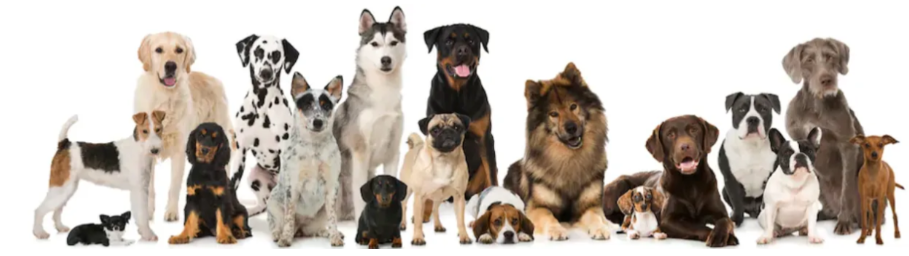

### The project's goal

The objective of this Notebook is to detail the implementation of a new algorithm for detecting the breed of the dog on a photo, in order to speed up the indexing work in a database.


During the previous project, I used CNN (Convolutional Neural Netwok) algorithms using transfer learning. I obtained satisfactory results, but the objective is to further improve the results.

After the introduction of transformers in NLP, they were used for image processing, and because of its success the CNN models became almost obsolete, for rebirth again, The facebook research center published an article that they called Convnet for 20s, whose goal is to take the benefits of the techniques used in transformers and implement them in ConvNext using ResNet. The idea is interesting in the sense that we have two branches for image modeling and classification.

the ConvNext algorithm is implemented in tansorflow, the [version 1](https://arxiv.org/pdf/2201.03545.pdf) was first released in March 2022, and the [version 2](https://arxiv.org/pdf/2301.00808.pdf) was released in January 2023.

**The Kaggle platform was used to be able to run the code in GPU.**


### Project Structure:

**1. Import the Libraries**

**2. Loading Data ad files**

**3. Visualize the data**

**4. Modeling**

### 1. Import the Libraries

Here we importing some important libraries and the required modules.

In [4]:
# load all required libraries for Dog's Breed Identification Project

import os
import matplotlib.pyplot as plt
import cv2 as cv
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import convnext
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from keras_tuner import RandomSearch
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
import gradio as gr
%matplotlib inline

### 2. Loading data and files

The objective is to compare the results between the MobileNet model and ConvNext, the same set of data is used.

In [5]:
images_dir = "/kaggle/input/images/Images"
# Use pathlib librairie
data_dir = pathlib.Path(images_dir)
data_dir

PosixPath('/kaggle/input/images/Images')

In [6]:
# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)

print('Total number of unique Dog Breeds:', len(breed_list))

Total number of unique Dog Breeds: 20


In [7]:
# Count total images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4244


### 3. Visualize the data

Here are nine images from different breed's dog:

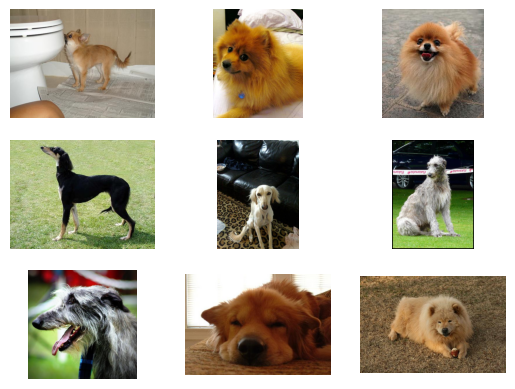

In [8]:
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img_test = str(list(data_dir.glob('*/*.jpg'))[i * 100])
    img_test = cv.imread(img_test)
    img_test = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
    plt.imshow(img_test)
    plt.axis('off')

Let’s check how many number of images for each dog breed in our dataset.

In [9]:
# Count number of pictures for each breed
breed_list = os.listdir(images_dir)
df_breeds = pd.DataFrame(index=[breed for breed in breed_list],
                         data=[len(os.listdir(images_dir + '/' + name))
                         for name in breed_list],
                         columns=['image_number'])

In [10]:
df_breeds.head()

,image_number
Pomeranian,219
Saluki,200
Scottish_deerhound,232
chow,196
EntleBucher,202


In [11]:
df_breeds.describe()

,image_number
count,20.000000
mean,212.200000
std,14.926487
min,196.000000
25%,201.500000
50%,209.500000
75%,218.000000
max,252.000000


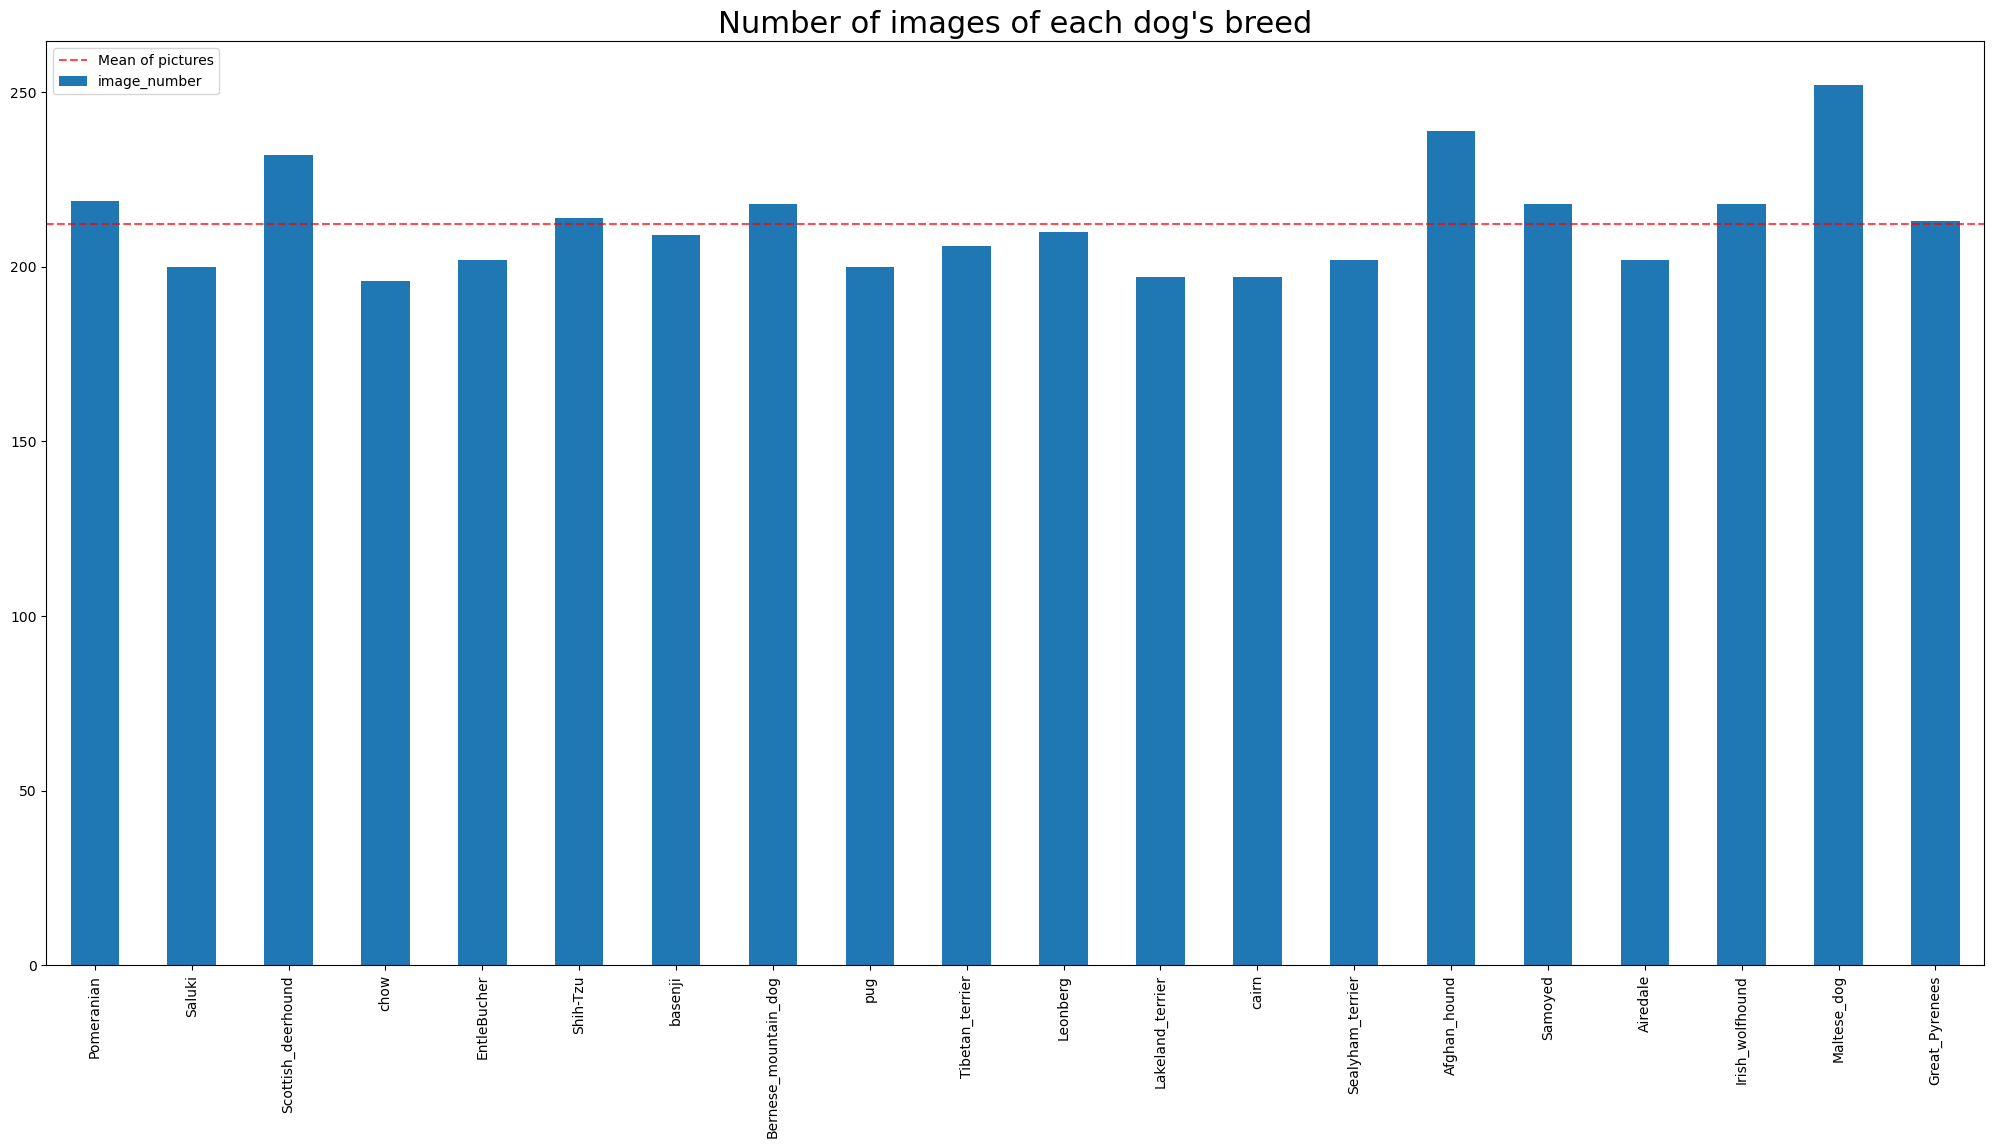

In [12]:
# Plot the distribution of the number of images of each breed.
(fig, ax) = plt.subplots(1, 1, figsize=(25, 12))
df_breeds.plot(kind='bar', legend=False, ax=ax)
ax.axhline(df_breeds['image_number'].mean(), color='r', alpha=.7,
           linestyle='--', label='Mean of pictures')
plt.title("Number of images of each dog's breed", size=22)
plt.legend()

The distribution is quite uniform for all the breeds, so there will be no need for imbalance-related treatment.

## 4. Modeling

No image preprocessing was used for MobileNet, here we will also not do any preprocessing.

### 4.1 ConvNext model

### Why ConvNext?

For many years, ConvNets has been used as the default model in image classification. But, this changed when Vision transformers, previously introduced to solve problems in Natural Language Processing (NLP), took over the state-of-the-art Convolutional Neural Network in solving image classification tasks.

The goal of ConvNext is to modernize the ResNet and bring back the glory to CNNs. In other words, the authors tried to apply the concepts of Transformers to ResNet like archtitecture and make them better. They individually applied ideas and showcased how much of an improvement it shows.

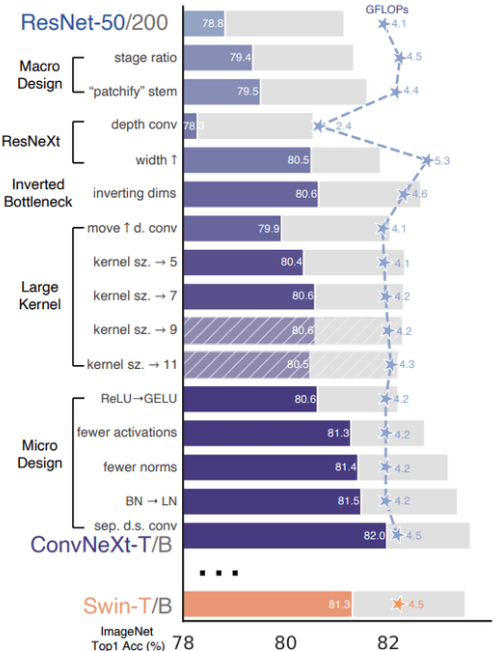

They compared the impact on 2 things : Accuracy and Computation.

Finally they reached the conclusion that following Changes enhances the results :

    -Large Kernel Size(7*7).
    -Replace ReLu with GeLu
    -Fewer Norm Layers
    -Substitute BatchNorm with LayerNorm
    -Inverted Block
    -Grouped Convs reduces computation
    -Add a "patchify layer"(to split an image into sequence of patches)

Below Image shows the comparison of ResNet, ViT with ConvNext. Diameter shows the Computation Power needed, hence more bigger the circle is, more computationally expensive model will be.

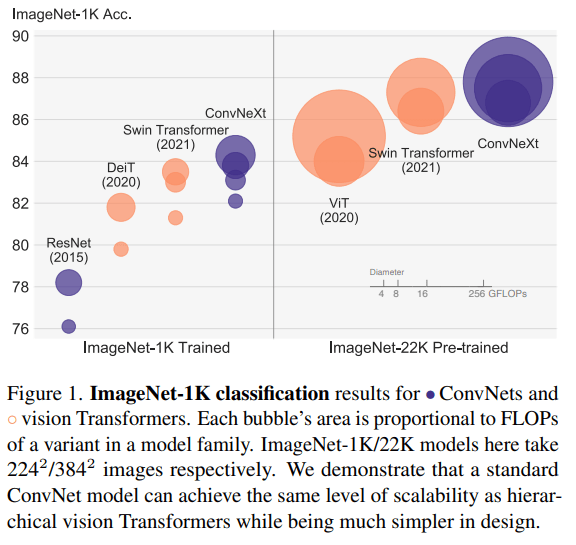

### Create a dataset

We initialize some parameters:

In [13]:
batch_size = 32
img_height = 160
img_width = 160
img_size = (img_height, img_width)

We load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. We use 80% of the images for training and 20% for validation.

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    )

Found 4244 files belonging to 20 classes.
Using 3396 files for training.


In [15]:
# Display the class names. These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['Afghan_hound', 'Airedale', 'Bernese_mountain_dog', 'EntleBucher', 'Great_Pyrenees', 'Irish_wolfhound', 'Lakeland_terrier', 'Leonberg', 'Maltese_dog', 'Pomeranian', 'Saluki', 'Samoyed', 'Scottish_deerhound', 'Sealyham_terrier', 'Shih-Tzu', 'Tibetan_terrier', 'basenji', 'cairn', 'chow', 'pug']


In [16]:
num_classes = len(class_names)
print('Number of classes in dataset:', num_classes)

Number of classes in dataset: 20


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    )

Found 4244 files belonging to 20 classes.
Using 848 files for validation.


As the original dataset doesn't contain a test set, we will create one. To do so, we determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [18]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [19]:
print('Number of validation batches: %d' \
    % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' \
    % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 22
Number of test batches: 5


In [20]:
for (image_batch, labels_batch) in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 160, 160, 3)
(32,)


We use buffered prefetching, so we can yield data from disk without having I/O become blocking. These are two important methods used when loading data:

- **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training our model. If our dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

- **Dataset.prefetch** overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal', 
                                input_shape = (img_height,img_width,3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1), 
])

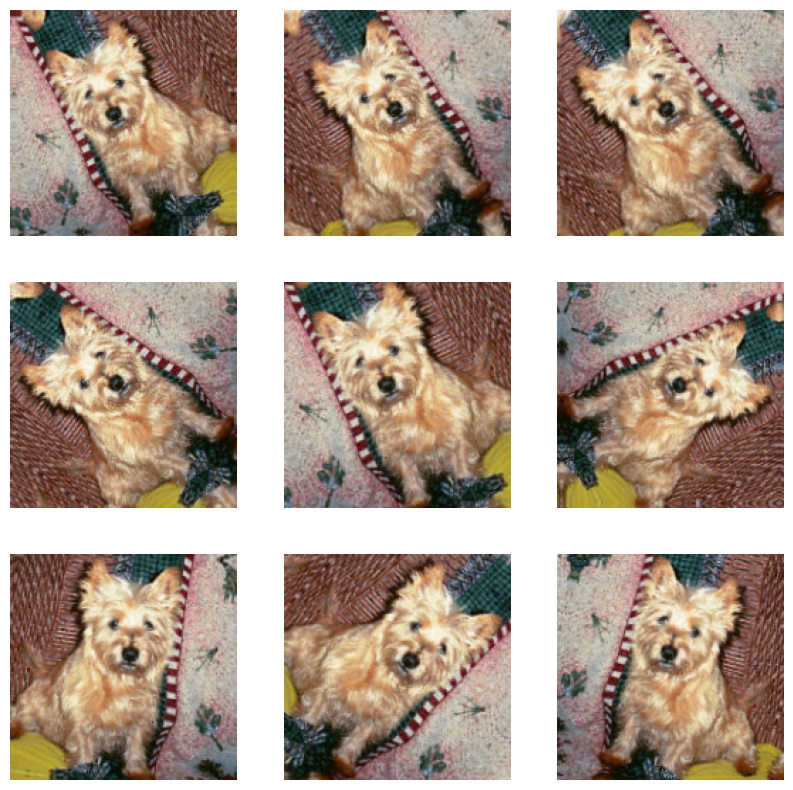

In [23]:
for image, _ in train_ds.take(1):
    plt.figure(figsize = (10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), 
                                            training = True)
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Choice of model

The base, large, and xlarge models were first pre-trained on the ImageNet-21k dataset and then fine-tuned on the ImageNet-1k dataset. In our case, we used the base model.

In [24]:
# use the Base version of convnext model 
convnext_base = tf.keras.applications.convnext.ConvNeXtBase(
                    include_top=False,     # drop the Dense layers!
                    weights='imagenet',    # use weights for ImageNet
                    input_shape=(img_height, img_width, 3)
                )

350926856/350926856 [==============================] - 2s 0us/step


In [25]:
preprocess_input = tf.keras.applications.convnext.preprocess_input

In [26]:
(image_batch, label_batch) = next(iter(train_ds))
feature_batch = convnext_base(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1024)


In [27]:
convnext_base.trainable = False

In [28]:
# Let's take a look at the base model architecture
convnext_base.summary()

Model: "convnext_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_prestem_normaliz  (None, 160, 160, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 40, 40, 128)  6528       ['convnext_base_prestem_normaliza
 )                                                               tion[0][0]']         

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [30]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 20)


In [31]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs, training=True)
x = preprocess_input(x)
x = convnext_base(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 5, 5, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 20)                20500     
                                                             

In [34]:
len(model.trainable_variables)

2

In [35]:
initial_epochs = 20
history_convnext = model.fit(train_ds, epochs=initial_epochs,
                        validation_data=val_ds)

Epoch 1/20
107/107 [==============================] - 78s 541ms/step - loss: 2.7831 - accuracy: 0.1584 - val_loss: 2.0813 - val_accuracy: 0.4578
Epoch 2/20
107/107 [==============================] - 47s 438ms/step - loss: 1.7164 - accuracy: 0.5701 - val_loss: 1.3194 - val_accuracy: 0.7355
Epoch 3/20
107/107 [==============================] - 45s 410ms/step - loss: 1.1715 - accuracy: 0.7450 - val_loss: 0.9746 - val_accuracy: 0.8212
Epoch 4/20
107/107 [==============================] - 45s 416ms/step - loss: 0.9113 - accuracy: 0.7992 - val_loss: 0.8111 - val_accuracy: 0.8227
Epoch 5/20
107/107 [==============================] - 44s 410ms/step - loss: 0.7671 - accuracy: 0.8245 - val_loss: 0.6909 - val_accuracy: 0.8561
Epoch 6/20
107/107 [==============================] - 44s 411ms/step - loss: 0.6669 - accuracy: 0.8436 - val_loss: 0.6250 - val_accuracy: 0.8532
Epoch 7/20
107/107 [==============================] - 45s 415ms/step - loss: 0.6034 - accuracy: 0.8519 - val_loss: 0.5749 - val_ac

### Visualize training results

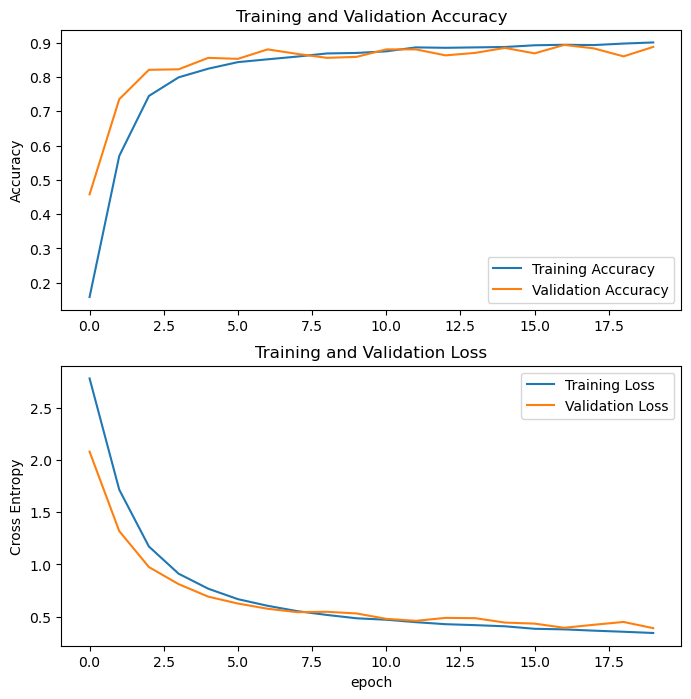

In [36]:
acc = history_convnext.history['accuracy']
val_acc = history_convnext.history['val_accuracy']

loss = history_convnext.history['loss']
val_loss = history_convnext.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])

plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,4.0])

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning ConvNext

In the feature extraction experiment, we were only training a few layers on top of an VGG16 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [37]:
convnext_base.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(convnext_base.layers))

Number of layers in the base model:  295


In [40]:
# Fine-tune from this layer onwards
fine_tune_at = 190 # the same percentage as MobileNet: 65%

# Freeze all the layers before the `fine_tune_at` layer
for layer in convnext_base.layers[:fine_tune_at]:
    layer.trainable = False

### Compile model

In [42]:
base_learning_rate = 1e-4

In [43]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 5, 5, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 20)                20500     
                                                             

In [45]:
len(model.trainable_variables)

123

In [47]:
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, epochs=total_epochs,
                         initial_epoch=history_convnext.epoch[-1],
                         validation_data=val_ds)

Epoch 20/40
107/107 [==============================] - 99s 581ms/step - loss: 0.3076 - accuracy: 0.9058 - val_loss: 0.3493 - val_accuracy: 0.9041
Epoch 21/40
107/107 [==============================] - 57s 533ms/step - loss: 0.2624 - accuracy: 0.9178 - val_loss: 0.3830 - val_accuracy: 0.8779
Epoch 22/40
107/107 [==============================] - 56s 519ms/step - loss: 0.2392 - accuracy: 0.9249 - val_loss: 0.3365 - val_accuracy: 0.8852
Epoch 23/40
107/107 [==============================] - 56s 518ms/step - loss: 0.2161 - accuracy: 0.9299 - val_loss: 0.3053 - val_accuracy: 0.9041
Epoch 24/40
107/107 [==============================] - 56s 517ms/step - loss: 0.2014 - accuracy: 0.9311 - val_loss: 0.2696 - val_accuracy: 0.9084
Epoch 25/40
107/107 [==============================] - 56s 519ms/step - loss: 0.1777 - accuracy: 0.9432 - val_loss: 0.3088 - val_accuracy: 0.8997
Epoch 26/40
107/107 [==============================] - 56s 517ms/step - loss: 0.1830 - accuracy: 0.9435 - val_loss: 0.2768 -

### Visualize training results

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

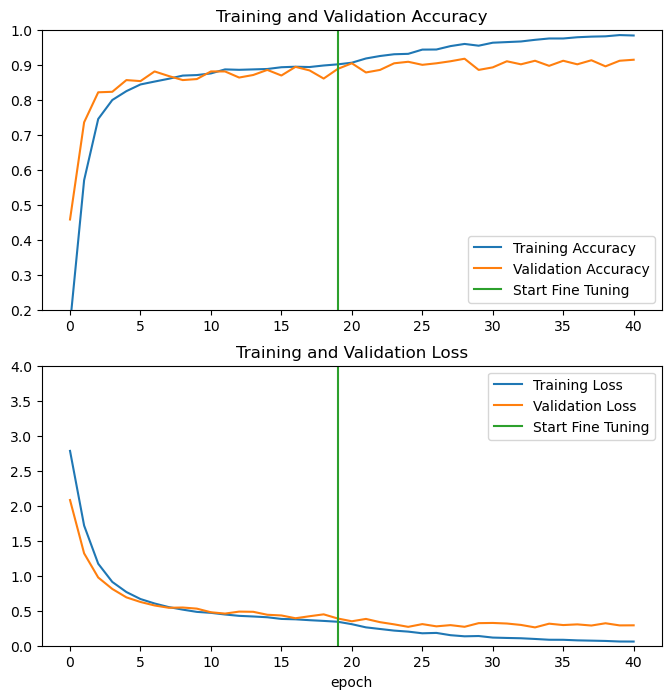

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(),
         label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(),
         label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [50]:
(loss, accuracy) = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

5/5 [==============================] - 2s 340ms/step - loss: 0.3241 - accuracy: 0.9187
Test accuracy : 0.918749988079071


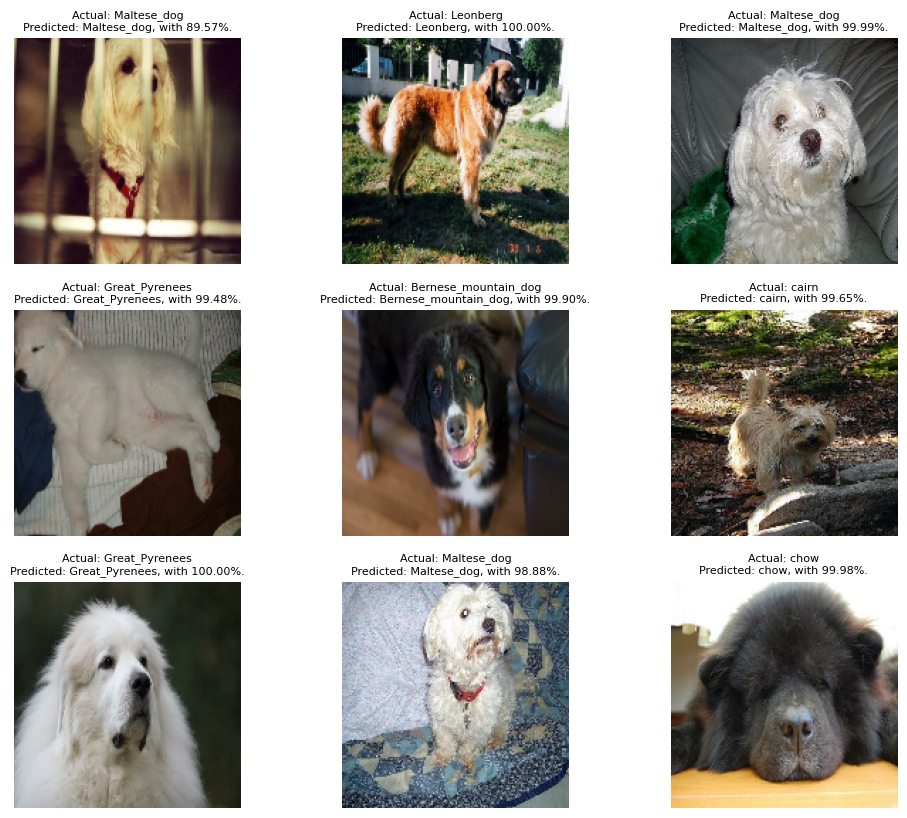

In [60]:
# Retrieve a batch of images from the test set
(image_batch, label_batch) = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a softmax
score = tf.nn.softmax(predictions)
fig = plt.figure(figsize=(12, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title('Actual: {}\nPredicted: {}, with {:.2f}%.'.format(class_names[label_batch[i]],
              class_names[np.argmax(score[i])], 100 * np.max(score[i])),size=8)
    plt.axis('off')

### Confusion Matrix

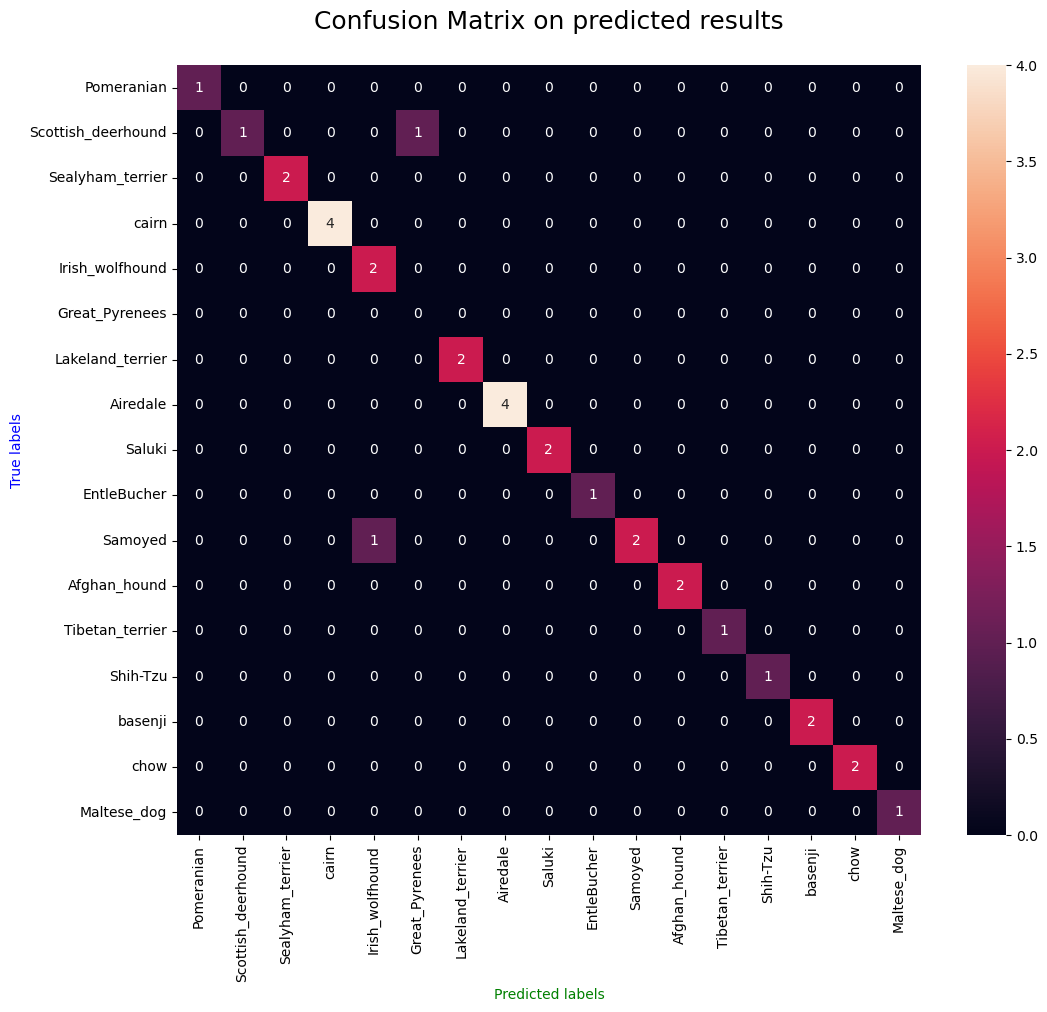

In [52]:
label = [class_names[i] for i in list(set(label_batch))]

y_test = [class_names[label_batch[i]] for i in range(len(label_batch))]
y_pred = [class_names[np.argmax(score[i])] for i in
          range(len(label_batch))]
label = list(set(y_pred + y_test))  # [class_names[i] for i in list(set(y_test))]
cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel('Predicted labels', color='g')
ax.set_ylabel('True labels', color='blue')
ax.xaxis.set_ticklabels(label, rotation='vertical')
ax.yaxis.set_ticklabels(label, rotation='horizontal')
plt.title('Confusion Matrix on predicted results\n', fontsize=18)
plt.show()

In [53]:
# Save the last model
history_fine.model.save('convnext_model.h5')
print("model saved")

model saved


In [3]:
#model = load_model('/kaggle/working/convnext_model.h5')

In [67]:
# Define the full prediction function
def breed_prediction(img):
    """Prediction of dog's breed.

    Args:
        img: image of a dog to detect its breed
    Returns:
        Dictionary of dog's breed and score.

    """
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    (img_height, img_width) = (160, 160)
    img = cv.resize(img, (img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    
    # predict
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0]).numpy()

    return {class_names[np.where(score==score[i])[0][0]]: float(score[i]) for i in range(len(class_names))}
    
# Construct the interface using gradio
image = gr.inputs.Image(shape=(160, 160))
label = gr.outputs.Label(num_top_classes=5)

gr.Interface(fn=breed_prediction, inputs=image, outputs=label,
             capture_session=True).launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://816969cda4f4ac001e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 62ms/step


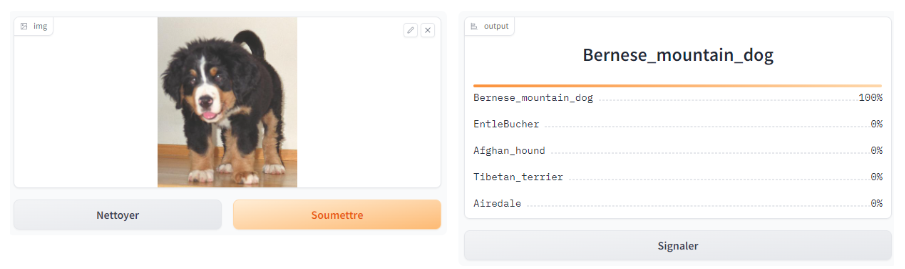